# INFO 4604 - Applied Machine Learning Final Project

### Erica Lee | Fall 2020 | December 9, 2020

## Original Question: How similar were my favorite songs released in 2020?

I spent a lot of my year, especially during quarantine, discovering new songs and artists, many of which had released new music. Because of how my taste in music has expanded and changed, I wanted to see if I could identify patterns between a set of 200 songs that I really liked, all released in 2020. Using audio features given by Spotify's API, I want to explore how my favorite songs of 2020 are similar and different from one another. 

## Midterm Project Expansion 

For my midterm, I used kNN, a _supervised_ learning method, to predict whether or not I like a song based on its audio features. I created two playlists, one with 100 songs I like and one with 100 songs I dislike. I then used k Nearest Neighbors to predict whether or not I would like those songs based on patterns in both playlist's audio features. 

For the final, I wanted to continue using the Spotify API since music is very important to me. This time, I'll be using k Means, an _unsupervised_ method to group together 200 of my favorite songs released in 2020 into different clusters based on their audio features. Depending on how these songs are clustered together, I'll be able to see how similar all these songs were to one another and look at the traits of my music taste during this past year.

## Data (writing)

In order to answer my question, I decided to make a playlist of 200 songs that I liked, all which came out in 2020. I will use Spotipy to first gather the name and id of each track in the playlist using the playlist_items method. I will then iterate through each song in the playlist to get each song's audio features to create the dataset for my KMeans algorithm. This will be done using the audio_features method from Spotipy. The features I will be focusing on are danceablity, energy, and valence. I will also gather the popularity score for each song.

In [123]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import numpy as np
import pprint as pprint
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import preprocessing

In [124]:
with open('secret.txt', 'r') as csecret:
    secret = csecret.read() # client secret
    
with open('clientid.txt', 'r') as cid:
    client_id = cid.read() # client id
    
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id = client_id,
                                                                              client_secret = secret))

In [125]:
# get each song id, name, artist, and popularity score from the playlist 
playlist_songs = []

results = spotify.playlist_items(playlist_id = '0WHcbNCpwlWatQuSfGLpQw') # id for my playlist of 200 songs
tracks = results['items']

# Source: https://stackoverflow.com/questions/57808711/spotipy-collecting-spotify-track-uris-from-a-user-playlist
# in order to gather more than 100 results, use a while loop 
while results['next']: 
    results = spotify.next(results)
    tracks.extend(results['items'])

for song in tracks:
    for artist in song['track']['album']['artists']:
        playlist_songs.append({'name':song['track']['name'],'id':song['track']['id'],'artist':artist['name'],
                              'popularity':song['track']['popularity']})
    
playlist_df = pd.DataFrame(playlist_songs)
playlist_df = playlist_df[['id','name','artist','popularity']] # set order of columns

playlist_df.head(25)

,id,name,artist,popularity
0,4Ksj9mKfsYC5b8v8Ey3c8I,0.00,Childish Gambino,48
1,07FOCFJhMmCVQDyWX1d3gR,Algorhythm,Childish Gambino,55
2,2Aq78kKI9yuloJQkcbhQbU,Time (feat. Ariana Grande),Childish Gambino,56
3,011ZwIM48eD8ee2UBpG8nK,"12.38 (feat. 21 Savage, Ink & Kadhja Bonet)",Childish Gambino,63
4,5X4R93Qcw54yp9Utwy7Mlr,19.10,Childish Gambino,57
5,3IB89bAf5k60jLUFoWAmn1,24.19,Childish Gambino,52
6,5UxxCtrLtSqOVRBQQn4ZJ3,32.22,Childish Gambino,47
7,4vS4FB3HXgOSmICeqEY0Gh,35.31,Childish Gambino,55
8,2VMzIZtoTgnKydwx6cRPq7,39.28,Childish Gambino,47
9,5CTzapBNGovLrqPas4cy7J,42.26,Childish Gambino,52


In [126]:
# get the audio features for each track

audio_features = []
for song_id in playlist_df['id']: # iterate through each song id in the dataframe from above
    features = spotify.audio_features(song_id) # use audio_features method to get each song's audio features
    for a in features:
        audio_features.append({'danceablity':a['danceability'],
                          'energy':a['energy'],
                          'valence':a['valence']})
    
features_df = pd.DataFrame(audio_features)

# add song name, artist, and popularity to the features_df
features_df['name'] = playlist_df['name']
features_df['artist'] = playlist_df['artist']
features_df['popularity'] = playlist_df['popularity']

print(len(features_df))
features_df.head(25)

201


,danceablity,energy,valence,name,artist,popularity
0,0.174,0.0466,0.0337,0.00,Childish Gambino,48
1,0.715,0.6490,0.4780,Algorhythm,Childish Gambino,55
2,0.621,0.5380,0.3110,Time (feat. Ariana Grande),Childish Gambino,56
3,0.691,0.5240,0.4100,"12.38 (feat. 21 Savage, Ink & Kadhja Bonet)",Childish Gambino,63
4,0.715,0.5970,0.1860,19.10,Childish Gambino,57
5,0.538,0.4630,0.2070,24.19,Childish Gambino,52
6,0.708,0.6360,0.4870,32.22,Childish Gambino,47
7,0.798,0.5590,0.6040,35.31,Childish Gambino,55
8,0.440,0.1060,0.1750,39.28,Childish Gambino,47
9,0.576,0.4860,0.1780,42.26,Childish Gambino,52


## Audio Features Key

**Danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**Energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

**Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). 

_More about audio features:_ https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

**Popularity:** Measure from 0 to 100, with 100 being most popular. 

## Model Selection and Tuning

1. Why is your model an appropriate choice for your data? 
    - Using the KMeans cluster method made the most sense, because I am trying to find the songs that are most similar to one another. Clustering the songs with similar audio features together will allow me to find songs that sound alike. 
2. What hyperparameters does your model have and how did you select them? 
    - The hyperparameters I had to account for were the number of clusters. I chose six clusters using trial and error by testing n_clusters = 4, 5, and 6. I go into more detail on this in the error analysis section.
3. What features did you choose and why? You must engineer at least 1 feature.
    - The feature I engineered was the label for what cluster each song belonged in. This is seen in the 'cluster' column in features_df, where a song will be grouped into a cluster from 0 to 5. This is ultimately how I can see which songs are most similar, and how I can analyze each cluster for what made them unique. 

**Resources I Used:**

- Preprocessing: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
- KMeans: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- Plotting: https://medium.com/pursuitnotes/k-means-clustering-model-in-6-steps-with-python-35b532cfa8ad

### Preprocessing

In [127]:
features = features_df.drop(columns=['name','artist','popularity']) 
# drop the name column so the dataframe only contains audio features

x = features.values # get the values from features_df
min_max_scaler = preprocessing.MinMaxScaler() # define the min max scaler

x_scaled = min_max_scaler.fit_transform(x) # fit, and then transform the values from features
# x_scaled makes the values normalized against each other, making it easier to estimate the minimum and maximum
# values of a model. 

### Model Tuning
#### _NOTE: IF YOU THIS BLOCK THE PREDICTIONS WILL CHANGE_

In [128]:
kmeans = KMeans(n_clusters=6) # instantiate kmeans method

kmeans_ = kmeans.fit_predict(x_scaled) # use fit_predict method to fit the scaled audio features data to the
# KMeans method, then predict the clusters each song belongs in

kmeans_

array([5, 0, 1, 0, 1, 1, 0, 0, 5, 1, 0, 2, 4, 0, 0, 4, 1, 1, 0, 4, 1, 0,
       4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 5, 1, 4, 4, 2,
       3, 3, 3, 3, 0, 0, 0, 0, 2, 3, 1, 3, 3, 0, 3, 1, 2, 1, 3, 0, 2, 1,
       4, 2, 1, 3, 1, 0, 1, 2, 1, 2, 3, 3, 2, 1, 0, 2, 3, 0, 3, 0, 1, 2,
       2, 5, 3, 5, 0, 5, 0, 0, 4, 0, 1, 5, 5, 4, 0, 5, 5, 1, 0, 4, 1, 4,
       4, 1, 0, 4, 3, 3, 0, 4, 4, 4, 5, 4, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 3, 1, 1, 2, 0, 5, 1, 0, 2, 1, 2, 0, 0, 0, 2, 3, 1, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 3, 3, 3, 1, 1, 2, 2, 1, 3, 3, 2,
       3, 0, 0, 3, 0, 0, 5, 5, 0, 0, 2, 0, 3, 2, 3, 2, 0, 1, 0, 0, 3, 3,
       1, 0, 3], dtype=int32)

### Adding Clusters to the Original Dataframe

In [129]:
kmeans_df = pd.DataFrame(kmeans_, dtype=int) # create a df with the cluster that was assigned to each song
kmeans_df.columns = ['cluster']

kmeans_df.head()

,cluster
0,5
1,0
2,1
3,0
4,1


In [130]:
features_df['cluster'] = kmeans_df['cluster'] # add cluster to original features df
features_df.head()

,danceablity,energy,valence,name,artist,popularity,cluster
0,0.174,0.0466,0.0337,0.00,Childish Gambino,48,5
1,0.715,0.6490,0.4780,Algorhythm,Childish Gambino,55,0
2,0.621,0.5380,0.3110,Time (feat. Ariana Grande),Childish Gambino,56,1
3,0.691,0.5240,0.4100,"12.38 (feat. 21 Savage, Ink & Kadhja Bonet)",Childish Gambino,63,0
4,0.715,0.5970,0.1860,19.10,Childish Gambino,57,1


## Results

Using K-Means, I was able to cluster 200 of my favorite songs from 2020 into six groups based on similarities in their audio features. Below are three graphs, visualizing each cluster based on where each song landed for the danceability, energy and valence values. Each dot is a song, and each color is a cluster. The yellow dot is the centroid for each cluster. Following the graphs, each cluster is examined to see which songs landed in which cluster. Lastly, the average values by each cluster are examined to make overarching claims about what each cluster represents. 

### Danceability & Energy

Text(0, 0.5, 'Energy')

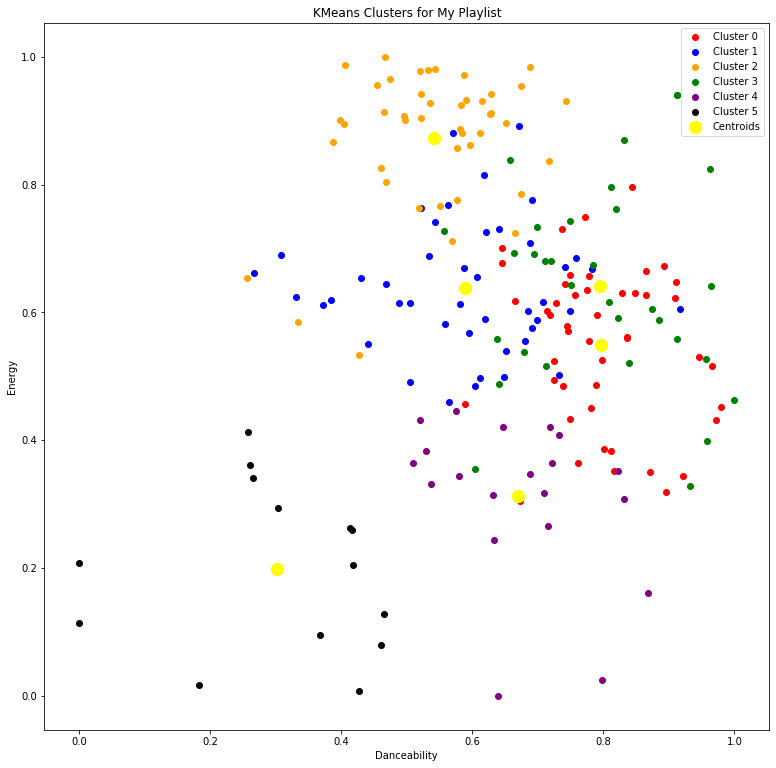

In [131]:
fig, ax = plt.subplots(figsize=(13,13))

# plot the scaled danceability on x axis, and scaled energy on y axis
plt.scatter(x_scaled[kmeans_ == 0,0],x_scaled[kmeans_ == 0,1], c='red', label='Cluster 0')
plt.scatter(x_scaled[kmeans_ == 1,0],x_scaled[kmeans_ == 1,1], c='blue', label='Cluster 1')
plt.scatter(x_scaled[kmeans_ == 2,0],x_scaled[kmeans_ == 2,1], c='orange', label='Cluster 2')
plt.scatter(x_scaled[kmeans_ == 3,0],x_scaled[kmeans_ == 3,1], c='green', label='Cluster 3')
plt.scatter(x_scaled[kmeans_ == 4,0],x_scaled[kmeans_ == 4,1], c='purple', label='Cluster 4')
plt.scatter(x_scaled[kmeans_ == 5,0],x_scaled[kmeans_ == 5,1], c='black', label='Cluster 5')

# plot the centroid
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=150, c='yellow', label='Centroids')

plt.legend()
plt.title('KMeans Clusters for My Playlist')
plt.xlabel('Danceability')
plt.ylabel('Energy')

### Energy & Valence

Text(0, 0.5, 'Valence')

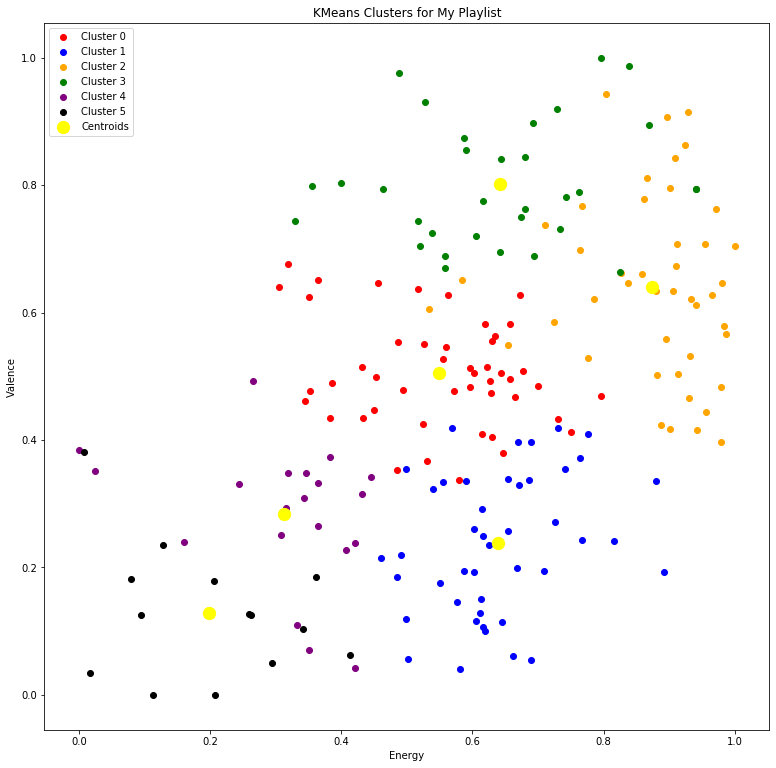

In [132]:
fig, ax = plt.subplots(figsize=(13,13))

# plot the scaled energy on x axis, and scaled valence on y axis
plt.scatter(x_scaled[kmeans_ == 0,1],x_scaled[kmeans_ == 0,2], c='red', label='Cluster 0')
plt.scatter(x_scaled[kmeans_ == 1,1],x_scaled[kmeans_ == 1,2], c='blue', label='Cluster 1')
plt.scatter(x_scaled[kmeans_ == 2,1],x_scaled[kmeans_ == 2,2], c='orange', label='Cluster 2')
plt.scatter(x_scaled[kmeans_ == 3,1],x_scaled[kmeans_ == 3,2], c='green', label='Cluster 3')
plt.scatter(x_scaled[kmeans_ == 4,1],x_scaled[kmeans_ == 4,2], c='purple', label='Cluster 4')
plt.scatter(x_scaled[kmeans_ == 5,1],x_scaled[kmeans_ == 5,2], c='black', label='Cluster 5')

# plot the centroid
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=150, c='yellow', label='Centroids')

plt.legend()
plt.title('KMeans Clusters for My Playlist')
plt.xlabel('Energy')
plt.ylabel('Valence')

### Danceability & Valence

Text(0, 0.5, 'Valence')

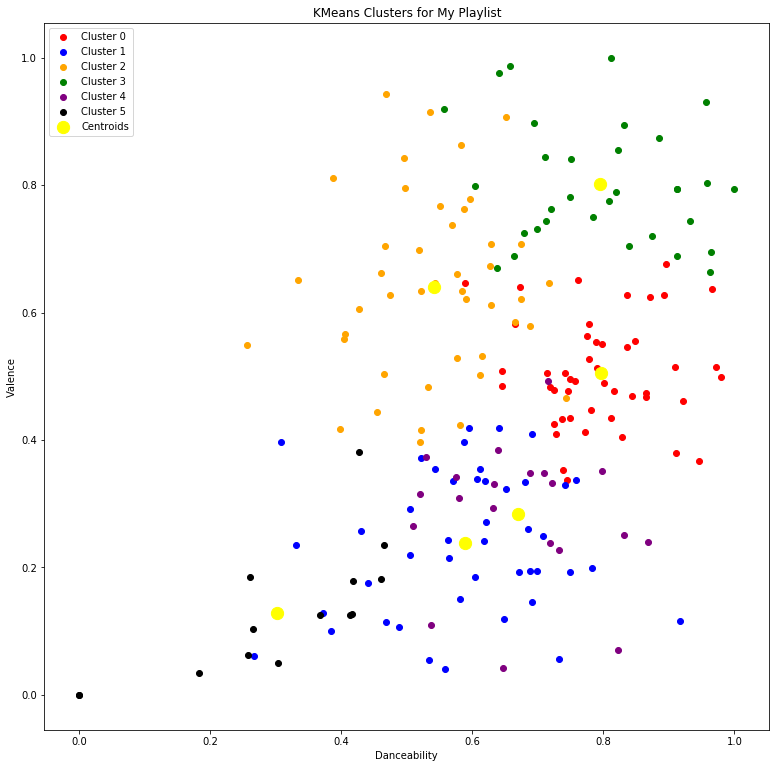

In [133]:
fig, ax = plt.subplots(figsize=(13,13))

# plot the scaled danceability on x axis, and scaled valence on y axis
plt.scatter(x_scaled[kmeans_ == 0,0],x_scaled[kmeans_ == 0,2], c='red', label='Cluster 0')
plt.scatter(x_scaled[kmeans_ == 1,0],x_scaled[kmeans_ == 1,2], c='blue', label='Cluster 1')
plt.scatter(x_scaled[kmeans_ == 2,0],x_scaled[kmeans_ == 2,2], c='orange', label='Cluster 2')
plt.scatter(x_scaled[kmeans_ == 3,0],x_scaled[kmeans_ == 3,2], c='green', label='Cluster 3')
plt.scatter(x_scaled[kmeans_ == 4,0],x_scaled[kmeans_ == 4,2], c='purple', label='Cluster 4')
plt.scatter(x_scaled[kmeans_ == 5,0],x_scaled[kmeans_ == 5,2], c='black', label='Cluster 5')

# plot the centroid
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s=150, c='yellow', label='Centroids')

plt.legend()
plt.title('KMeans Clusters for My Playlist')
plt.xlabel('Danceability')
plt.ylabel('Valence')

## Songs from Each Cluster

### CLUSTER 0 - RED

In [134]:
cluster0 = features_df[features_df['cluster'] == 0]
cluster0

,danceablity,energy,valence,name,artist,popularity,cluster
1,0.715,0.649,0.478,Algorhythm,Childish Gambino,55,0
3,0.691,0.524,0.410,"12.38 (feat. 21 Savage, Ink & Kadhja Bonet)",Childish Gambino,63,0
6,0.708,0.636,0.487,32.22,Childish Gambino,47,0
7,0.798,0.559,0.604,35.31,Childish Gambino,55,0
10,0.681,0.597,0.486,47.48,Childish Gambino,53,0
13,0.831,0.360,0.601,Complicated,Mac Miller,58,0
14,0.742,0.553,0.508,Blue World,Mac Miller,59,0
18,0.779,0.362,0.460,Woods,Mac Miller,58,0
21,0.739,0.627,0.542,Hands,Mac Miller,54,0
48,0.855,0.331,0.652,Kiss U Right Now,Duckwrth,60,0


In [135]:
print('Cluster 0: '+str(len(cluster0))+' songs')

Cluster 0: 47 songs


### CLUSTER 1 - BLUE

In [136]:
cluster1 = features_df[features_df['cluster'] == 1]
cluster1

,danceablity,energy,valence,name,artist,popularity,cluster
2,0.621,0.538,0.3110,Time (feat. Ariana Grande),Childish Gambino,56,1
4,0.715,0.597,0.1860,19.10,Childish Gambino,57,1
5,0.538,0.463,0.2070,24.19,Childish Gambino,52,1
9,0.576,0.486,0.1780,42.26,Childish Gambino,52,1
16,0.699,0.503,0.0546,I Can See,Mac Miller,56,1
17,0.875,0.599,0.1120,Everybody,Mac Miller,57,1
20,0.583,0.499,0.3420,That's On Me,Mac Miller,55,1
26,0.255,0.653,0.0580,Alone Again,The Weeknd,62,1
27,0.640,0.869,0.1850,Too Late,The Weeknd,62,1
28,0.466,0.609,0.1030,Hardest To Love,The Weeknd,61,1


In [137]:
print('Cluster 1: '+str(len(cluster1))+' songs')

Cluster 1: 44 songs


### CLUSTER 2 - ORANGE

In [138]:
cluster2 = features_df[features_df['cluster'] == 2]
cluster2

,danceablity,energy,valence,name,artist,popularity,cluster
11,0.518,0.952,0.622,53.49,Childish Gambino,53,2
36,0.684,0.817,0.623,Save Your Tears,The Weeknd,63,2
43,0.408,0.532,0.584,New Love Song,Duckwrth,44,2
52,0.318,0.580,0.627,Jean's Smoke Break,Duckwrth,1,2
60,0.599,0.915,0.590,Dead Weight,PVRIS,42,2
64,0.635,0.711,0.563,Hallucinations,PVRIS,42,2
67,0.497,0.881,0.611,January Rain,PVRIS,42,2
73,0.709,0.905,0.449,Dead Weight - Nicole Moudaber Remix,PVRIS,40,2
75,0.447,0.786,0.908,Burden,Aminé,58,2
78,0.550,0.760,0.509,"Roots (feat. JID, Charlie Wilson)",Aminé,58,2


In [139]:
print('Cluster 2: '+str(len(cluster2))+' songs')

Cluster 2: 44 songs


### CLUSTER 3 - GREEN

In [140]:
cluster3 = features_df[features_df['cluster'] == 3]
cluster3

,danceablity,energy,valence,name,artist,popularity,cluster
35,0.667,0.720,0.705,In Your Eyes,The Weeknd,61,3
44,0.870,0.556,0.664,Money Dance,Duckwrth,46,3
45,0.611,0.489,0.940,Trickin'?,Duckwrth,5,3
46,0.914,0.406,0.774,Quick,Duckwrth,50,3
47,0.954,0.466,0.765,Too Bad,Duckwrth,42,3
53,0.772,0.610,0.747,Super Bounce,Duckwrth,64,3
55,0.920,0.634,0.669,Tuesday,Duckwrth,46,3
56,0.774,0.779,0.963,World On Wheels,Duckwrth,44,3
58,0.793,0.848,0.861,Find A Way,Duckwrth,41,3
62,0.609,0.556,0.646,Good to Be Alive,PVRIS,42,3


In [141]:
print('Cluster 3: '+str(len(cluster3))+' songs')

Cluster 3: 32 songs


### CLUSTER 4 - PURPLE

In [142]:
cluster4 = features_df[features_df['cluster'] == 4]
cluster4

,danceablity,energy,valence,name,artist,popularity,cluster
12,0.610,0.0316,0.3700,Circles,Mac Miller,60,4
15,0.794,0.3200,0.2410,Good News,Mac Miller,59,4
19,0.677,0.3300,0.3360,Hand Me Downs,Mac Miller,57,4
22,0.828,0.1820,0.2310,Surf,Mac Miller,57,4
23,0.762,0.0540,0.3390,Once A Day,Mac Miller,55,4
24,0.682,0.2810,0.4750,Right,Mac Miller,68,4
25,0.505,0.3910,0.3600,Floating,Mac Miller,62,4
41,0.689,0.3740,0.3210,Missed You - Bonus Track,The Weeknd,72,4
42,0.604,0.2600,0.3180,Final Lullaby - Bonus Track,The Weeknd,68,4
66,0.486,0.3740,0.2550,Loveless,PVRIS,42,4


In [143]:
print('Cluster 4: '+str(len(cluster4))+' songs')

Cluster 4: 20 songs


### CLUSTER 5 - BLACK

In [144]:
cluster5 = features_df[features_df['cluster'] == 5]
cluster5

,danceablity,energy,valence,name,artist,popularity,cluster
0,0.174,0.0466,0.0337,0.00,Childish Gambino,48,5
8,0.440,0.1060,0.1750,39.28,Childish Gambino,47,5
39,0.249,0.3700,0.1780,Until I Bleed Out,The Weeknd,58,5
89,0.253,0.3520,0.0990,Dreamland,Glass Animals,52,5
91,0.000,0.1380,0.0000,((home movie: 1994)),Glass Animals,0,5
93,0.000,0.2260,0.0000,((home movie: btx)),Glass Animals,0,5
99,0.394,0.2780,0.1210,It’s All So Incredibly Loud,Glass Animals,45,5
100,0.397,0.2750,0.1220,((home movie: rockets)),Glass Animals,34,5
103,0.407,0.0390,0.3670,((home movie: shoes on)),Glass Animals,35,5
104,0.289,0.3070,0.0477,Helium,Glass Animals,43,5


In [145]:
print('Cluster 5: '+str(len(cluster5))+' songs')

Cluster 5: 14 songs


## Average Values by Cluster

In [146]:
averages = features_df.groupby(features_df['cluster']).mean() # group by cluster, then find mean values for 
# the audio features and popularity per cluster

averages['# songs'] = features_df['cluster'].value_counts() # count number of songs in each cluster

averages

,danceablity,energy,valence,popularity,# songs
cluster,,,,,
0,0.759851,0.547021,0.486447,56.446809,47
1,0.562386,0.630864,0.229005,57.818182,44
2,0.516136,0.851273,0.617068,53.250000,44
3,0.759062,0.633844,0.771750,53.031250,32
4,0.639550,0.324680,0.272845,48.950000,20
5,0.288643,0.218043,0.123114,42.000000,14


### What Do Songs in Each Cluster Have In Common?

**Cluster 0:** Largest cluster with 47 songs. Contained songs with the highest average danceability. Second highest average popularity. 

**Cluster 1:** Songs averaged the highest popularity. 

**Cluster 2:** Contained songs with the highest average energy. 

**Cluster 3:** Contained songs with high average danceability (but not the highest) and the highest average valence.

**Cluster 4:** Nothing particularly stands out about this cluster, it seems to be a relatively average set of songs with high danceabiity, low energy and low valence.

**Cluster 5:** Smallest cluster, with only 14 songs. Songs averaged the lowest popularity. Contained songs with the lowest average danceability, lowest average energy, and lowest average valence. 

## Error Analysis

Error analysis for unsupervised machine learning methods is difficult, because unlike the kNN model I used last time, there's no "correct" answer for me to compare the assigned clusters to. However, I can look at the accuracy of the model using the score method from KMeans, which returns a number. A score closer to 0 means the clusters were grouped together well, while a larger negative number means the clusters took no distinct form and the clusters weren't distinct enough to be valid groups. The score of my model was at -7.8, meaning there is siginificant room for improvement. I chose to only use 6 clusters for the scope of the project, as printing out more groups individually was an exhaustive task, which is why I only decided to go as far as using six clusters. I recognize this score as a large error and mostly wanted to keep the project within a reasonable level for the sake of this project. 

For the future, I would consider using more than six clusters, and probably use 30 clusters to only return an error of -2.0 (as shown in the score_df below). Finally, using the inertia_ attribute from sklearn, which is defined as the "sum of squared distances of samples to their closest cluster center", I can see that in order to produce the most accurate model possible, I need to use > 30 clusters because that is where the line starts to flatten out, meaning the model will not get any better if I use more clusters, making it the "sweet spot". 

In [147]:
score_ = []

# look at the score for what 1-50 clusters would look like
for i in range(1,51):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x_scaled)
    score_.append({'# clusters':i,'score':kmeans.score(x_scaled)})

score_df = pd.DataFrame(score_)
score_df

,# clusters,score
0,1,-28.885245
1,2,-17.503610
2,3,-13.214173
3,4,-10.534326
4,5,-9.035751
5,6,-7.820689
6,7,-6.835322
7,8,-6.371309
8,9,-5.852775
9,10,-5.468110


In [148]:
# the score for six clusters, which is what i used
score_df[score_df['# clusters'] == 6]

,# clusters,score
5,6,-7.820689


Text(0, 0.5, 'inertia')

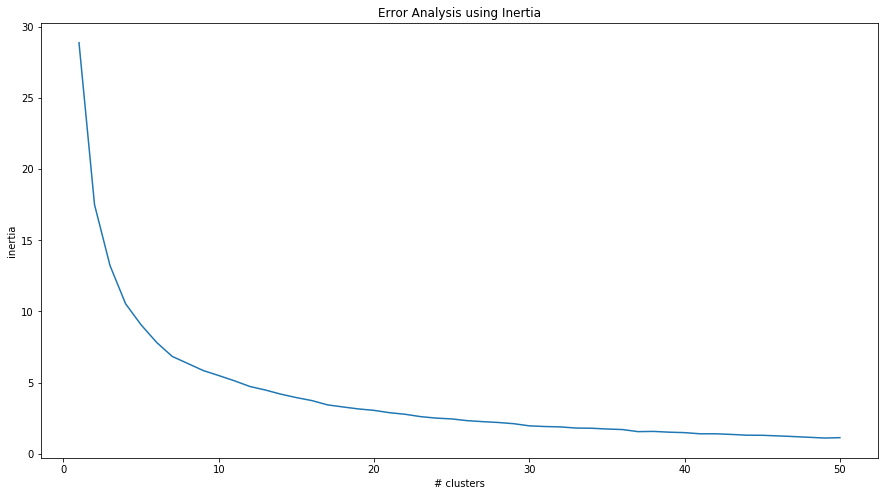

In [149]:
cluster_ = []

for i in range(1,51):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x_scaled)
    cluster_.append(kmeans.inertia_) # use the inertia_ attribute

plt.figure(figsize=(15,8))
plt.plot(range(1,51), cluster_)

plt.title('Error Analysis using Inertia')
plt.xlabel('# clusters')
plt.ylabel('inertia')

## Discussion

Just by looking at the songs and artists that were aggregated together in each cluster and knowing what each one sounds like, I think the model did a decent (but not perfect) job of grouping similar songs together into six different clusters. Clusters 0, 3, and 5 stood out the most to me.


- **Cluster 0:** Largest cluster with 47 songs. Contained songs with the highest average danceability. Second highest average popularity. 
- **Cluster 1:** Songs averaged the highest popularity. 
- **Cluster 2:** Contained songs with the highest average energy. 
- **Cluster 3:** Contained songs with high average danceability (but not the highest) and the highest average valence.
- **Cluster 4:** Nothing particularly stands out about this cluster, it seems to be a relatively average set of songs with high danceabiity, low energy and low valence.
- **Cluster 5:** Smallest cluster, with only 14 songs. Songs averaged the lowest popularity. Contained songs with the lowest average danceability, lowest average energy, and lowest average valence. 

**Cluster 0** was the largest cluster, containing 47 songs. The songs in this cluster had the highest average danceability, meaning the tempo, rhythm and stability of the song made the songs more danceable than the rest of the songs. 
**Cluster 3** had very high danceability (almost the highest) and high valence, meaning songs in this cluster were very happy sounding and upbeat. 
**Cluster 5** had the lowest average valence, energy, AND danceability amongst the rest of the clusters. Songs in this cluster were likely very angry, sad, melancholy, and slow-paced tracks. Their energy was extremely low, so the songs were likely more loud and noisy. In addition, this cluster had the lowest average popularity. 

In the future, I would love to explore the popularity ranking further. I think it was really interesting that Cluster 0 contained very danceable songs and ranked highly in terms of popularity within my dataset. It would be worth exploring a playlist of the top 50 charting songs in the USA and seeing whether or not they have similar audio features to my Cluster 0. Furthermore, I think I could also explore whether or not different artists were grouped into certain clusters and make conclusions on the general traits of their music based on that. 